In [2]:
import os
os.environ["NUMBA_DISABLE_JIT"] = "1"
import numpy as np
import sympy as sp
from IPython.display import HTML, display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from open_atmos_jupyter_utils import show_plot
from PyMPDATA import Solver, ScalarField, VectorField, Stepper, Options
from PyMPDATA.boundary_conditions import Periodic


In [32]:
mu = 0.001 # diffusion coefficient
dt = 0.0005
tmax = 5.0
nt = int(tmax / dt)

nx = 100
ux  = 0.25

omega = np.pi

min_x, max_x = -1, 1
dx = (max_x - min_x) / nx
Cx = ux * dt / dx

In [33]:
def analytic_solution(x, t):
    # gaussian bump centered at -0.5
    # with amplitude 1
    # and width 0.1
    return np.exp(-((x+0.5)/0.1)**2) - np.exp(-((x-0.5)/0.1)**2) + 1.5

def z(t):
    return np.array(
    [
        analytic_solution(x, t=t) for x in np.linspace(min_x, max_x, nx)
    ],
    dtype=float
)

In [34]:
u0 = z(t=0)

Text(0, 0.5, 'advectee')

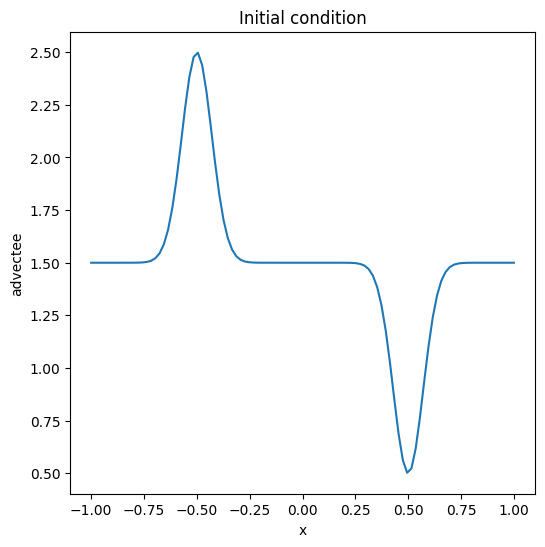

In [35]:
plt.figure(figsize=(6, 6))
plt.plot(np.linspace(min_x, max_x, nx), u0, label='Initial condition')
plt.title('Initial condition')
plt.xlabel('x')
plt.ylabel('advectee')

In [36]:
opts = Options(n_iters=3, non_zero_mu_coeff=True, infinite_gauge=True, nonoscillatory=True)

boundary_conditions = (Periodic(),)
stepper = Stepper(options=opts, n_dims=len(u0.shape), non_unit_g_factor=False)
solver = Solver(stepper=stepper,
                advectee=ScalarField(u0.astype(dtype=opts.dtype), halo=opts.n_halo,
                                         boundary_conditions=boundary_conditions),
                advector=VectorField((np.full(u0.shape[0] + 1, 0, dtype=opts.dtype),), halo=opts.n_halo,
                                         boundary_conditions=boundary_conditions)
                )

In [37]:
print("CFL number: ", Cx)
print("Diffusion number: ", mu)
print("nt: ", nt)

CFL number:  0.00625
Diffusion number:  0.001
nt:  10000


In [38]:
solver.advance(nt, mu_coeff=(mu,))

8312985.4